## Импорты, воспроизводимость, выбор устройства

In [1]:
import os
import random
from dataclasses import dataclass

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt


def set_global_seed(seed: int = 42) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_global_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Загрузка датасета

In [2]:
data_path = "https://drive.google.com/uc?export=download&id=1DeLBxjmp0cw6g-UUzmZ9HFkcjdmlnjs2"
df = pd.read_csv(data_path)
df.shape, df.columns.tolist()[:20]

((10000, 16),
 ['svcscan.fs_drivers',
  'callbacks.ngeneric',
  'psxview.not_in_eprocess_pool_false_avg',
  'psxview.not_in_eprocess_pool',
  'callbacks.nanonymous',
  'psxview.not_in_session',
  'psxview.not_in_pslist',
  'psxview.not_in_pspcid_list',
  'psxview.not_in_ethread_pool',
  'psxview.not_in_csrss_handles',
  'psxview.not_in_pslist_false_avg',
  'psxview.not_in_pspcid_list_false_avg',
  'psxview.not_in_deskthrd',
  'psxview.not_in_ethread_pool_false_avg',
  'psxview.not_in_session_false_avg',
  'Class'])

## Разделение на train/val/test (60/20/20) со стратификацией

In [3]:
y_raw = df["Class"]
X_raw = df.drop(columns=["Class"])

if not pd.api.types.is_numeric_dtype(y_raw):
    y = pd.Series(pd.factorize(y_raw)[0], index=y_raw.index, name="Class")
else:
    y = y_raw.astype(int)

unique = sorted(pd.unique(y))
if unique != [0, 1]:
    raise ValueError(f"Ожидались бинарные метки 0/1, но получено: {unique}")

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_raw, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

(X_train.shape, X_val.shape, X_test.shape, y_train.mean(), y_val.mean(), y_test.mean())


((6000, 15),
 (2000, 15),
 (2000, 15),
 np.float64(0.5096666666666667),
 np.float64(0.5095),
 np.float64(0.5095))

## Препроцессинг признаков

Признаки разделяются на числовые и категориальные по типам данных. 

Для числовых: заполняем пропуски медианой (устойчиво к выбросам), затем стандартизируем `StandardScaler` (ноль-среднее, единичное отклонение) - это сильно помогает MLP обучаться быстрее и стабильнее. 

Для категориальных: заполняем пропуски самым частым значением и кодируем `OneHotEncoder(handle_unknown="ignore")`, чтобы новые категории на val/test не ломали преобразование.

In [4]:
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

X_train_np = preprocess.fit_transform(X_train)
X_val_np = preprocess.transform(X_val)
X_test_np = preprocess.transform(X_test)

X_train_np.shape, X_val_np.shape, X_test_np.shape


((6000, 15), (2000, 15), (2000, 15))

## PyTorch Dataset и DataLoader

Далее создается класс `TabularDataset`, который хранит `X` и `y`. Целевая переменная `y` приводится к форме `(N, 1)`, потому что модель выдает вероятность в таком же виде. 

Далее создаются `DataLoader` для train/val/test: для train включен `shuffle=True`. 

`batch_size` выбран как 256: стабильные градиенты, обычно без проблем по памяти. Если есть GPU, включаем `pin_memory` для ускорения передачи данных на устройство. Также фиксируем `input_dim` - число входных признаков после one-hot и стандартизации, оно понадобится при создании модели.

In [5]:
class TabularDataset(Dataset):
    def __init__(self, X: np.ndarray, y: pd.Series):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.to_numpy().astype(np.float32)).unsqueeze(1)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]


batch_size = 256
pin = device.type == "cuda"

train_ds = TabularDataset(X_train_np, y_train)
val_ds = TabularDataset(X_val_np, y_val)
test_ds = TabularDataset(X_test_np, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=pin)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=pin)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=pin)

input_dim = X_train_np.shape[1]
input_dim

15

## Бейзлайн MLP (архитектура и forward)

Здесь реализуется базовая нейросетевая модель MLP для бинарной классификации. Архитектура - два скрытых слоя (128 и 64 нейрона). Это дает сети способность моделировать нелинейные зависимости, но еще не переобучается. В качестве активации используется `ReLU` - дефолтный выбор для MLP из-за простой оптимизации и хорошей практической сходимости. Последний слой - один нейрон, затем `Sigmoid`, чтобы получить вероятность класса 1 в диапазоне [0, 1]. После определения класса создается экземпляр модели и переносится на `device` (GPU/CPU).

In [6]:
class MLPBaseline(nn.Module):
    def __init__(self, input_dim: int, hidden1: int = 128, hidden2: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


baseline_model = MLPBaseline(input_dim=input_dim).to(device)
baseline_model

MLPBaseline(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

## Train-loop / Eval-loop и инфраструктура обучения

Две ключевые функции:

* `train_one_epoch`: выполняет один проход по train-даталоадеру. Для каждого батча переносим данные на устройство, обнуляем градиенты, считаем предсказания, loss, делаем `backward()` и шаг оптимизатора. Возвращаем средний loss по эпохе.

* `eval_epoch`: выполняет оценку на val/test без градиентов (`@torch.no_grad()`), считает средний loss и собирает вероятности и истинные метки, чтобы затем посчитать метрики классификации.

Далее задается `TrainConfig`: гиперпараметры обучения (learning rate, weight_decay, число эпох, patience для early stopping). Функция `fit_model` запускает цикл обучения, сохраняет историю `train_loss`, `val_loss`, `val_f1`, и реализует early stopping по `val_loss`. Лучшая модель выбирается по минимальному `val_loss` и сохраняется как `state_dict` в памяти.

In [7]:
@torch.no_grad()
def eval_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module, device: torch.device):
    model.eval()
    losses = []
    probs_all = []
    y_all = []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        pb = model(xb)
        loss = criterion(pb, yb)
        losses.append(loss.item())
        probs_all.append(pb.detach().cpu().numpy())
        y_all.append(yb.detach().cpu().numpy())
    probs = np.vstack(probs_all).reshape(-1)
    y_true = np.vstack(y_all).reshape(-1).astype(int)
    return float(np.mean(losses)), y_true, probs


def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer,
                    criterion: nn.Module, device: torch.device):
    model.train()
    losses = []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        pb = model(xb)
        loss = criterion(pb, yb)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    return float(np.mean(losses))


@dataclass
class TrainConfig:
    lr: float = 1e-3
    weight_decay: float = 1e-4
    epochs: int = 60
    patience: int = 8


def fit_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, cfg: TrainConfig, device: torch.device):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    history = {"train_loss": [], "val_loss": [], "val_f1": []}
    best_state = None
    best_val = float("inf")
    bad_epochs = 0

    for epoch in range(1, cfg.epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, y_true, probs = eval_epoch(model, val_loader, criterion, device)
        y_pred = (probs >= 0.5).astype(int)
        val_f1 = f1_score(y_true, y_pred)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_f1)

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= cfg.patience:
                break

    if best_state is None:
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    model.load_state_dict(best_state)
    model.to(device)
    return model, history

## Обучение бейзлайна и визуализация динамики

Здесь мы обучаем бейзлайн модель и строим графики. Оптимизатор выбран `Adam`: он устойчив к масштабу градиентов и быстрее находит рабочие решения. `lr=1e-3` - стандартный дефолт, `weight_decay=1e-4` добавляет мягкую L2-регуляризацию, часто улучшая обобщение. Запускаем `fit_model`, получаем историю, затем строим:

* график `train_loss` и `val_loss` по эпохам, чтобы видеть сходимость и возможное переобучение,
* график `val_f1`, чтобы понимать, как меняется классификационное качество.
  В конце выводятся ключевые числа: сколько эпох реально прошло (учитывая early stopping), минимальный `val_loss` и максимальный `val_f1`.

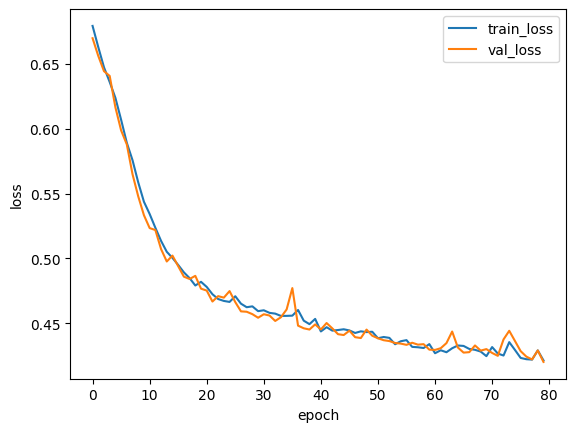

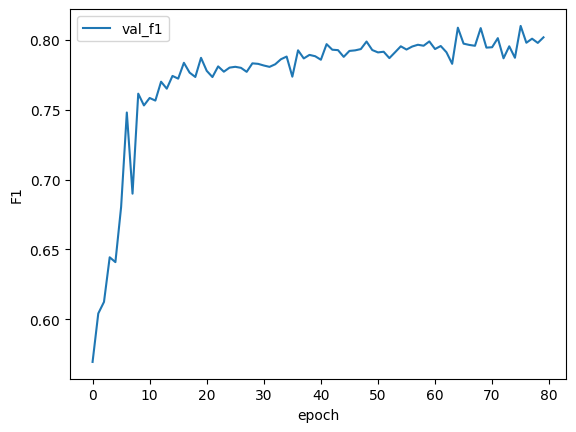

(80, 0.4201628193259239, 0.8099255583126551)

In [8]:
set_global_seed(42)

baseline_model = MLPBaseline(input_dim=input_dim).to(device)
cfg_base = TrainConfig(lr=1e-3, weight_decay=1e-4, epochs=80, patience=10)

baseline_model, hist_base = fit_model(baseline_model, train_loader, val_loader, cfg_base, device)

plt.figure()
plt.plot(hist_base["train_loss"], label="train_loss")
plt.plot(hist_base["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist_base["val_f1"], label="val_f1")
plt.xlabel("epoch")
plt.ylabel("F1")
plt.legend()
plt.show()

len(hist_base["train_loss"]), min(hist_base["val_loss"]), max(hist_base["val_f1"])


## Оценка бейзлайна на тесте и отчет классификации

Эта ячейка измеряет качество уже обученной (лучшей по val_loss) модели на test-выборке. Считается `test_loss` через `BCELoss`, затем получаем вероятности и переводим их в классы порогом 0.5. Далее выводим:

* `ROC-AUC` как порогонезависимую метрику,
* `confusion_matrix` для понимания ошибок по классам,
* `classification_report` (precision/recall/F1 для каждого класса и средние значения).
  Это финальная проверка бейзлайна.

In [9]:
criterion = nn.BCELoss()
test_loss, y_true_test, probs_test = eval_epoch(baseline_model, test_loader, criterion, device)
y_pred_test = (probs_test >= 0.5).astype(int)

print("Test loss:", test_loss)
print("Test ROC-AUC:", roc_auc_score(y_true_test, probs_test))
print("Confusion matrix:\n", confusion_matrix(y_true_test, y_pred_test))
print(classification_report(y_true_test, y_pred_test, digits=4))


Test loss: 0.4261534884572029
Test ROC-AUC: 0.8830837932493629
Confusion matrix:
 [[771 210]
 [197 822]]
              precision    recall  f1-score   support

           0     0.7965    0.7859    0.7912       981
           1     0.7965    0.8067    0.8016      1019

    accuracy                         0.7965      2000
   macro avg     0.7965    0.7963    0.7964      2000
weighted avg     0.7965    0.7965    0.7965      2000



## Улучшенная архитектура: добавляем BatchNorm и Dropout

В этой ячейке создается улучшенная версия MLP, где изменения ограничены требованиями пункта 6: добавляются `BatchNorm1d` и `Dropout`. Архитектура становится более устойчивой:

* `BatchNorm1d` ставится сразу после `Linear` и до `ReLU`. Это стандартная и обычно наиболее эффективная схема.
* `Dropout` ставится после `ReLU`. Так мы убираем уже активированные признаки, уменьшая риск переобучения.
* Размеры скрытых слоев чуть увеличены (256 и 128), потому что регуляризация позволяет держать большую емкость модели без резкого переобучения.
  На выходе по-прежнему `Sigmoid`, чтобы оставаться совместимыми с `nn.BCELoss`.


In [10]:
class MLPBNDropout(nn.Module):
    def __init__(self, input_dim: int, hidden1: int = 256, hidden2: int = 128, p: float = 0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


## Подбор Dropout p по валидации

Здесь делается подбор гиперпараметра `p` для Dropout. Необходимо сравнить несколько вариантов на одинаковом разбиении и при фиксированном seed.

Функция `fit_and_score(p)`:

* фиксирует seed,
* создает модель с конкретным `p`,
* обучает ее с early stopping,
* оценивает на валидации `val_loss`, `val_f1`, `val_auc`,
* сохраняет `state_dict` лучшей модели (чтобы потом не переобучать заново).

Перебираем набор `p` и собираем таблицу результатов. Сортировка идет по `val_f1` и `val_auc` - так мы выбираем вариант, который реально лучше классифицирует.

Почему `lr` снижен до `5e-4`: при наличии Dropout обучение часто становится чуть более шумным; меньший шаг делает сходимость стабильнее и облегчает сравнение конфигураций.

In [11]:
def fit_and_score(p: float, seed: int = 42):
    set_global_seed(seed)
    model = MLPBNDropout(input_dim=input_dim, hidden1=256, hidden2=128, p=p).to(device)
    cfg = TrainConfig(lr=5e-4, weight_decay=1e-4, epochs=120, patience=12)
    model, hist = fit_model(model, train_loader, val_loader, cfg, device)

    criterion = nn.BCELoss()
    val_loss, y_true, probs = eval_epoch(model, val_loader, criterion, device)
    y_pred = (probs >= 0.5).astype(int)
    val_f1 = f1_score(y_true, y_pred)
    val_auc = roc_auc_score(y_true, probs)
    return {
        "p": p,
        "best_val_loss": float(np.min(hist["val_loss"])),
        "final_val_loss": float(val_loss),
        "val_f1": float(val_f1),
        "val_auc": float(val_auc),
        "epochs_ran": len(hist["val_loss"]),
        "model_state": {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
        "history": hist,
    }


ps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
results = [fit_and_score(p) for p in ps]

summary = pd.DataFrame([{k: v for k, v in r.items() if k not in {"model_state", "history"}} for r in results])
summary.sort_values(["val_f1", "val_auc"], ascending=False)


,p,best_val_loss,final_val_loss,val_f1,val_auc,epochs_ran
3,0.3,0.385690,0.385690,0.826942,0.904145,120
1,0.1,0.391266,0.391266,0.825147,0.902949,86
4,0.4,0.400464,0.400464,0.824450,0.898290,120
2,0.2,0.400095,0.400095,0.819961,0.896691,86
5,0.5,0.405355,0.405355,0.810163,0.898446,120
0,0.0,0.435832,0.435832,0.800384,0.882315,39


## Финальная модель (лучшая BN+Dropout) и тест

В этой ячейке выбирается лучший `p` по результатам валидации, затем собирается финальная улучшенная модель и загружаются сохраненные веса (лучшие по val_loss в рамках выбранного эксперимента). После этого:

* строятся графики `train_loss` и `val_loss`, а также `val_f1` именно для лучшей конфигурации, чтобы визуально оценить поведение обучения,
* выполняется оценка на test: `test_loss`, `ROC-AUC`, `confusion_matrix`, `classification_report`.

Это дает релевантное сравнение с бейзлайном: одинаковые разбиения, одинаковые метрики, улучшение достигнуто только за счет BN и Dropout.

In [12]:
best_row = summary.sort_values(["val_f1", "val_auc"], ascending=False).iloc[0]
best_p = float(best_row["p"])
best_p


0.3

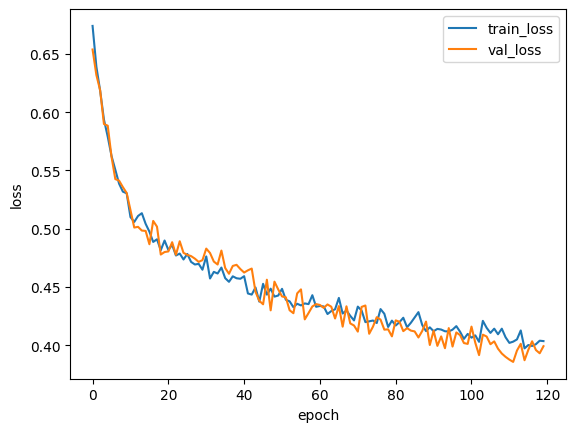

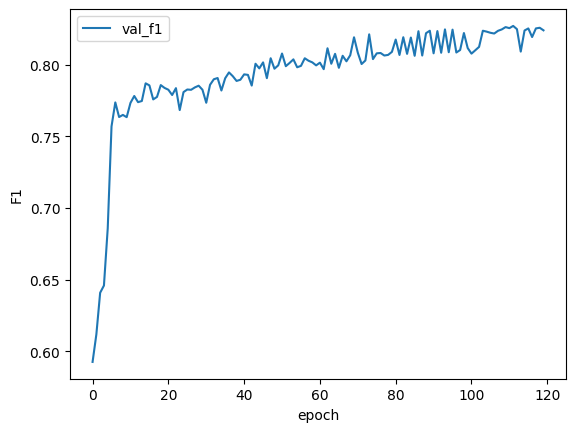

Chosen dropout p: 0.3
Test loss: 0.4054637663066387
Test ROC-AUC: 0.8997453080562081
Confusion matrix:
 [[801 180]
 [178 841]]
              precision    recall  f1-score   support

           0     0.8182    0.8165    0.8173       981
           1     0.8237    0.8253    0.8245      1019

    accuracy                         0.8210      2000
   macro avg     0.8209    0.8209    0.8209      2000
weighted avg     0.8210    0.8210    0.8210      2000



In [13]:
best_idx = int(summary.sort_values(["val_f1", "val_auc"], ascending=False).index[0])
best_state = results[best_idx]["model_state"]
best_hist = results[best_idx]["history"]

final_model = MLPBNDropout(input_dim=input_dim, hidden1=256, hidden2=128, p=best_p).to(device)
final_model.load_state_dict(best_state)
final_model.to(device)

plt.figure()
plt.plot(best_hist["train_loss"], label="train_loss")
plt.plot(best_hist["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(best_hist["val_f1"], label="val_f1")
plt.xlabel("epoch")
plt.ylabel("F1")
plt.legend()
plt.show()

criterion = nn.BCELoss()
test_loss2, y_true_test2, probs_test2 = eval_epoch(final_model, test_loader, criterion, device)
y_pred_test2 = (probs_test2 >= 0.5).astype(int)

print("Chosen dropout p:", best_p)
print("Test loss:", test_loss2)
print("Test ROC-AUC:", roc_auc_score(y_true_test2, probs_test2))
print("Confusion matrix:\n", confusion_matrix(y_true_test2, y_pred_test2))
print(classification_report(y_true_test2, y_pred_test2, digits=4))


## Выводы по пункту 6

* `BatchNorm1d` для табличной MLP обычно ускоряет и стабилизирует сходимость за счет нормализации распределения активаций по батчу. На практике это часто дает более ровные кривые `val_loss` и меньше чувствительность к инициализации.
* Позиция `Linear -> BN -> ReLU` почти всегда выигрывает у `Linear -> ReLU -> BN`.
* `Dropout` логичнее ставить после активации: он убирает уже сформированные признаки. До ReLU он иногда ухудшает обучение.
* Оптимальный `p` зависит от размера датасета и количества признаков.
